# Evaluation
- EGNN generated ~60% higher binding affinity, but SE3 Transformer only ~0.04%. But SE3T obtained better CNN scores
   - This could be because the stretch of egnn generated mols are small, i.e., the atoms stay closely around the center.
   - SE3 Transformer generated normal stretch but we haven't manage to generate candidates with better binding affinity so far.
   - Actually SE3T might generate atoms too distant, so that during reconstruction they are not regarded as connected

In [1]:
import pandas as pd 
import numpy as np
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import re

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('../evaluation/')

In [4]:
from utils import build_pdb_dict

## MSE loss

In [38]:
bridge_type = 'vp'

# egnn
# fixed point init
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104'
# Gaussian noise init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248'

# transformer
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-01_21_36_34.208973'
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-05-31_23_42_37.443630'

# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_36_42.924053'
# root_path = '../lightning _logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_37_44.491071'

# only basic

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_28.164795'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_44.297462'

# basic + aromatic

root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_02_24_30.913781'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_13_18_12.746286'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-21_23_58_36.562980'

aromatic = True
# log_path = '../../docking_res/logs/' + bridge_type

In [33]:
bridge_type = 've'

# egnn
# root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_42.795058'
root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_52.002393'

aromatic = False

## CE/NLL loss

In [31]:
bridge_type = 'vp'

# egnn
# fixed point init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042'


aromatic = False

In [39]:
log_path = os.path.join(root_path, 'logs')
log_path = log_path+'_aromatic' if aromatic else log_path
gen_path = os.path.join(root_path, 'reconstructed_mols')
gen_path = gen_path+'_aromatic_mode' if aromatic else gen_path

raw_data_path = '../../data/cleaned_crossdocked_data/raw'

log_files = os.listdir(log_path)
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [40]:
len(log_files)

23309

In [41]:
def get_minimized_affinity(filename, mode='ref'):
    if mode == 'ref':
        with open(filename, 'r') as file:
            for line in file:
                if '<minimizedAffinity>' in line:
                    # The next line after '<minimizedAffinity>' contains the value
                    return float(next(file))
            
    else:
        with open(filename, 'r') as f:
            lines = f.readlines()
            lines = lines[19:28]
#             print(len(lines))
            n = len(lines)
            arr = np.zeros(n)
#             print(filename)
            for i in range(n):
                arr[i] = float(lines[i][11:17])
#             print(arr)
            try:
                score = np.min(arr)
            except:
                score = None
                print(f'{filename} failed')
                print('its scores: ', arr)
        return score

In [42]:
def get_affinity_best_pose(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = lines[19:28]
        try:
            score = float(lines[0][11:17])
            cnn_score = float(lines[0][34:42])
            # cnn_score = float(lines[0][24:30])
        except:
            score = None
            cnn_score = None
        return score, cnn_score

In [43]:
score_dict = {}
for log_file in tqdm(log_files):
    ligand_name = log_file.split('.')[0]
    ligand_file = ligand_name + '.sdf'
    pdb_folder = pdb_rev_dict[ligand_file]
    ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
    ref_score = get_minimized_affinity(ref_file, 'ref')
#     print(log_file)
    # gen_score = get_minimized_affinity(os.path.join(log_path, log_file), 'gen')
    gen_score, cnn_score = get_affinity_best_pose(os.path.join(log_path, log_file))
    score_dict[ligand_name] = [gen_score, cnn_score, ref_score]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23309/23309 [00:40<00:00, 574.53it/s]


In [44]:
df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['Binding affinity', 'CNN score', 'Reference'])
df

,Binding affinity,CNN score,Reference
4b05_A_rec_4djv_0km_lig_tt_docked_0,-6.00,0.7306,-9.97440
5pbm_A_rec_5cu8_54t_lig_tt_min_0,-4.19,0.8362,-4.58956
4p8l_A_rec_4p8t_r26_lig_tt_docked_9,-5.42,0.5789,-8.78517
5i2z_B_rec_3ehy_tbl_lig_tt_docked_10,-7.20,0.7851,-6.65387
4rvr_A_rec_5e9m_bae_lig_tt_min_0,-4.15,0.6532,-3.60079
...,...,...,...
4rvk_A_rec_4rvk_3xk_lig_tt_min_0,-5.68,0.2358,-9.90370
1ki7_A_rec_1e2p_ccv_lig_tt_min_0,-5.81,0.5439,-7.33492
3jzk_A_rec_4oq3_2v8_lig_tt_min_0,-3.56,0.7879,-8.27060
5ezz_A_rec_4djv_0km_lig_tt_min_0,-6.27,0.5042,-8.80099


In [45]:
filtered_df = df.loc[df['Binding affinity']<df['Reference']]
filtered_df

,Binding affinity,CNN score,Reference
5i2z_B_rec_3ehy_tbl_lig_tt_docked_10,-7.20,0.7851,-6.65387
4rvr_A_rec_5e9m_bae_lig_tt_min_0,-4.15,0.6532,-3.60079
5e73_A_rec_4cur_la7_lig_tt_min_0,-5.58,0.7829,-4.12373
5mhp_A_rec_5l0b_6zm_lig_it2_tt_docked_13,-6.26,0.7929,-5.35068
5ej9_A_rec_5ej6_td6_lig_it1_it2_tt_docked_2,-6.70,0.1181,-6.23842
...,...,...,...
5p91_A_rec_5p9d_d1d_lig_tt_min_0,-2.11,0.8426,-1.61522
1rak_A_rec_3rn6_iga_lig_tt_min_0,-4.37,0.9004,-2.97239
3ipx_A_rec_2qro_d5m_lig_tt_min_0,-5.44,0.5643,-4.08027
1jk3_A_rec_1rmz_ngh_lig_tt_min_0,-5.46,0.5661,-4.89139


In [46]:
sorted_df = filtered_df.sort_values(by='CNN score', ascending=False)
sorted_df

,Binding affinity,CNN score,Reference
5enk_A_rec_4j17_1hq_lig_tt_min_0,-5.98,0.9877,-5.02714
2j7b_A_rec_1oif_ifm_lig_it1_it2_tt_docked_4,-5.60,0.9732,-3.97538
4djy_A_rec_4x7i_3ys_lig_tt_min_0,-6.28,0.9713,-6.26387
4j17_A_rec_4hzt_0za_lig_tt_min_0,-5.84,0.9707,-5.57083
4zpg_A_rec_4j0p_1h8_lig_tt_min_0,-5.83,0.9701,-3.13985
...,...,...,...
1q6l_B_rec_1xbx_5rp_lig_tt_min_0,-6.73,0.1424,-6.02103
3w7o_B_rec_3w7k_w7k_lig_tt_docked_1,-9.57,0.1405,-9.28966
3w86_A_rec_3w2n_rod_lig_tt_min_0,-7.52,0.1225,-7.06892
5ej9_A_rec_5ej6_td6_lig_it1_it2_tt_docked_2,-6.70,0.1181,-6.23842


In [47]:
ba_res_filename = os.path.join(root_path, 'binding_affinity')
ba_res_filename = ba_res_filename+'_aromatic.csv' if aromatic else ba_res_filename+'.csv'

sorted_df.to_csv(ba_res_filename)

In [48]:
sum(df['Binding affinity'] < df['Reference']) / len(df)

0.07237547728345274

In [49]:
def test_ref_ligand(ligand, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    example = os.path.join(path, ligand+'.sdf')
    m = Chem.MolFromMolFile(example)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ligand+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ligand+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [61]:
lig = '2j7b_A_rec_1oif_ifm_lig_it1_it2_tt_docked_4'

In [62]:
pdb_rev_dict[lig+'.sdf']

'BGLA_THEMA_1_446_0'

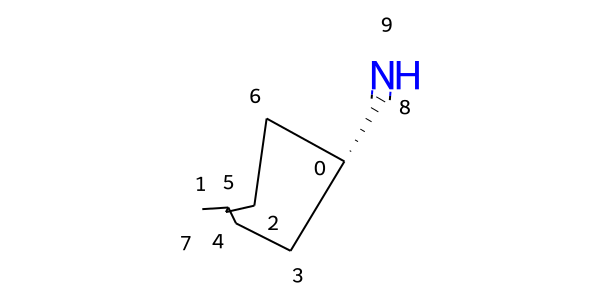

In [63]:
m, ref_m = test_ref_ligand(lig) 
m

[15:50:44] Molecule does not have explicit Hs. Consider calling AddHs()


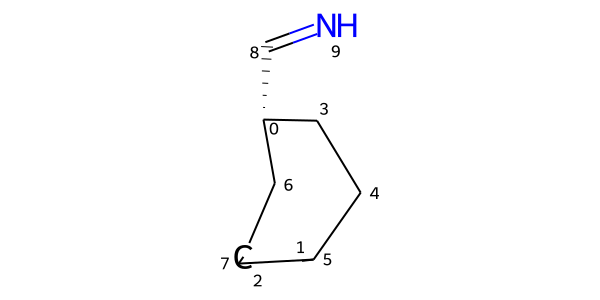

In [64]:
# m = Chem.AddHs(m, addCoord=True)
UFFOptimizeMolecule(m)
m

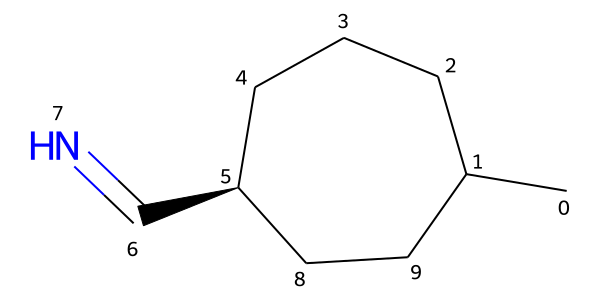

In [65]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

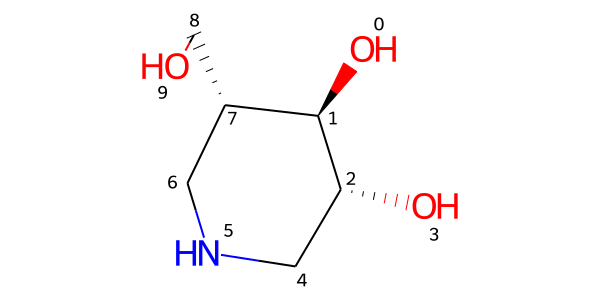

In [66]:
ref_m

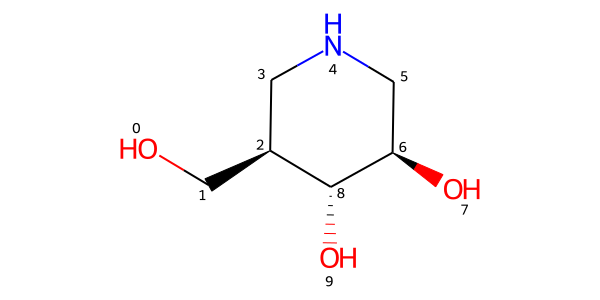

In [67]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [68]:
def viz(ligand, path=gen_path):
    example = os.path.join(path, ligand+'.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(example).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    
    return v

In [69]:
viz(lig)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [70]:
def viz_with_pr(ligand, root_path=root_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict, aromatic=True):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ligand)
    pdb_folder = pdb_rev_dict[ligand + '.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ligand[ligand.rfind('rec')+4:ligand.rfind('lig')+3]

    autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')

    out_folder = 'output_aromatic' if aromatic else 'output'
    out_file = os.path.join(root_path, out_folder, ligand + '.sdf')
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(protein_file).read())
    v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModelsAsFrames(open(out_file).read())
    v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    v.zoomTo({'model':1})
    v.rotate(90)
    v.animate({'interval':1000})
    
    return v

In [71]:
viz_with_pr(lig, aromatic=aromatic)

2j7b_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.